In [ ]:
%load_ext rpy2.ipython

In [2]:
%run nbinit.ipy 
import scipy

... Configuring matplotlib formats
... Configuring matplotlib with inline figures
... Importing numpy as np, scipy as sp, pyplot as plt, scipy.stats as stats
   ... scipy.signal as sig
... Importing widgets, display, HTML, Image, Javascript
... Some LaTeX definitions


... Defining figures captions 


... Loading customized Javascript for interactive solutions (show/hide)
... Redefining interactive from ipywidgets


In [3]:
%%HTML
<style>
em {
    color: green;
}
strong
{
    color: blue;
}
h1
{
    color: DarkBlue;
    //background-color: LightCyan; // LightBlue;
}
</style>

# Introduction 

Dans ce chapitre, on discutera de deux méthodes : la validation croisée et le *bootstrap*. Il s'agit d'outils indispensables, qui, à partir d'un ré-échantillonnage des données, c'est-à-dire en régénérant des échantillons à partir des données courantes, permettent d'obtenir des informations supplémentaires sur le modèle estimé. De telles informations ne sont pas disponibles à partir d'un simple apprentissage. C'est le fait de répéter cet apprentissage, à partir de données adéquatement regénérées, rééchantillonnées, que l'on va pouvoir accéder à ces informations. 

On pourra par exemple appécier la variabilité d'un modèle, estimer ses performances intrinsèques (*model assessment*), et plus que cela, aller vers la sélection de paramètres pertinents (*model selection*). 


# Évaluation des performances -- model assessment

## Un premier exemple : régression polynomiale

L'exemple présenté ici, retravaillé de  [underfitting_overfitting](http://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html) (documentation de scikit-learn), illustre les problèmes de sous et surparamétrisation (*underfitting* et *overfitting*). On considère un modèle de régression polynomial pour approximer une fonction non-linéaire bruitée. Pour un degré trop faible, l'approximation est pauvre, il y a du *biais*. Lorsqu'on augmente le degré du polynôme, l'approximation peut-être meilleure, mais l'approximation a aussi tendance à prendre en compte les irrégularités introduites par un bruit d'observation. Le modèle est alors **trop** fidèle aux données d'apprentissage et s'écarte du véritable modèle. Par suite, lorsqu'on cherche à généraliser, c'est-à-dire à utiliser le modèle sur de nouvelles données, l'erreur de test va se dégrader (*variance*). Un des grands problèmes dans la conception de modèles va être de trouver le meilleur modèle en évitant l'overfitting.

Dans cet exemple synthétique, puisque'on fabrique les données, on connait ce modèle de génération et on peut générer autant de données test que l'on veut afin d'évaluer la qualité des différents modèles. Ce n'est bien entendu pas le cas dans la « vraie vie », où on devra faire avec les données disponibles. La validation croisée, que l'on va présenter dans ce chapitre fournit une réponse à ces problématiques. 

La fonction de calcul de l'erreur moyenne donnée juste ci-dessous est utilisée pour générer de nouveaux échantillons test et calculer alors les scores pour un modèle de régression donné. Elle est utilisée dans la suite pour la démonstration des performances d'un modèle. 

In [4]:
def erreur_moyenne_test(M):
    scores=np.zeros(M)
    for m in range(M):
        ytest=np.cos(1.5 * np.pi * X) + np.random.randn(n_samples) * 0.1
        scores[m]=np.mean((reg.predict(XX)-ytest)**2)
    return scores   

Ces lignes simulent donc un modèle non-linéaire et comparent les performances de régression polynomiale pour différents degrés. 

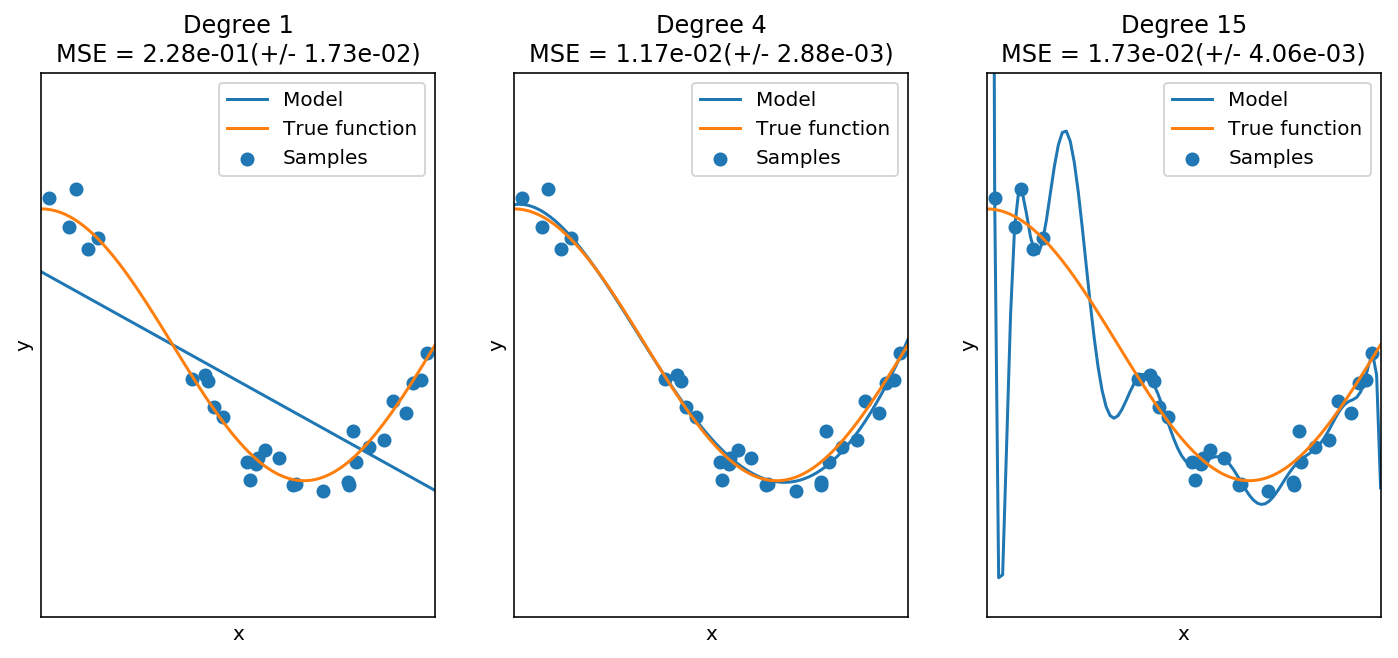

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn import cross_validation

np.random.seed(0)

n_samples = 30
degrees = [1, 4, 15]

true_fun = lambda X: np.cos(1.5 * np.pi * X)
X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

plt.figure(figsize=(12, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    poly = PolynomialFeatures(degree=degrees[i], include_bias=False)
    reg = LinearRegression()
    XX=poly.fit_transform(X[:,np.newaxis])
    reg.fit(XX, y)

    scores=erreur_moyenne_test(100)
    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, reg.predict(poly.fit_transform(X_test[:, np.newaxis])), 
             label="Model")
    plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title("Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(
        degrees[i], scores.mean(), scores.std()))
figcaption("Comparaison des résultats pour une régression polynomiale avec différents degrés",
              label="fig:compare_res_polreg")

Lorqu'on fait varier le degré du polynôme, la complexité du modèle croît, le biais diminue mais la variance augmente de son côté. On peut étudier les performances en traçant les estimées des erreurs quadratique sur la base d'apprentissage d'une part et sur le test d'autre part. Ici, on imagine disposer d'autant de bases de tests que l'on veut, et on peut donc estimer correctement l'erreur quadratique de test...

/home/bercherj/.local/lib/python3.5/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log
/home/bercherj/.local/lib/python3.5/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log


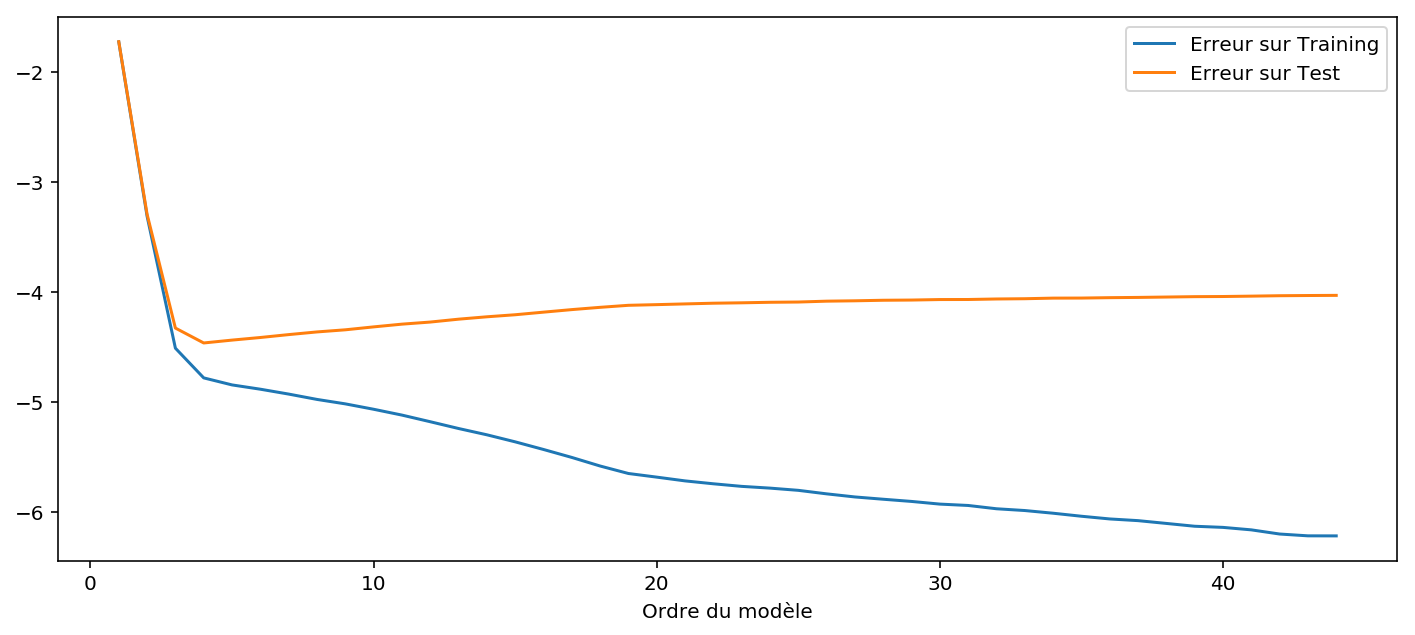

In [6]:
# Tracé des courbes de performance
# On tire au hasard une base d'apprentissage, une base de test
# On apprend sur l'apprentissage, puis on teste sur apprentissage et sur test
# ce pour tous les ordres possibles
# On itère là dessus M fois
plt.figure(figsize=(12, 5))

M = 200  # Nombre de jeux training/test utilisés

# Définition du problème simulé
n_samples = 30
true_fun = lambda X: np.cos(1.5 * np.pi * X)

# Degré max à tester 
max_order = 45
sc_test = np.zeros((max_order))
sc_training = np.zeros((max_order))

for m in range(M):
    X = np.sort(np.random.rand(n_samples))
    y = true_fun(X) + np.random.randn(n_samples) * 0.1  # jeu d'apprentissage
    ytest = true_fun(X) + np.random.randn(n_samples) * 0.1  # jeu de test

    for order in range(1, max_order):
        poly = PolynomialFeatures(degree=order)
        # permet de générer toutes les variables explicatives        
        XX = poly.fit_transform(X[:, np.newaxis])          
        reg = LinearRegression()  # instance régression linéaire 
        reg.fit(XX, y)  # apprentissage 
        sc_training[order] += np.mean(
            (reg.predict(XX) - y)**2)  # calcul RSS training
        sc_test[order] += np.mean(
            (reg.predict(XX) - ytest)**2)  # calcul RSS test      

sc_training = sc_training / M
sc_test = sc_test / M
plt.plot(np.log(sc_training), label="Erreur sur Training")
plt.plot(np.log(sc_test), label="Erreur sur Test")
plt.legend()
plt.xlabel("Ordre du modèle")
figcaption(
    "Comparaison des EQM sur Test et Training", label="compare_perfs_polreg")

In [7]:
import os
os.sys.platform

'linux'

## Second exemple : un problème de discrimination

On considère maintenant un exemple synthétique pour un problème discrimination entre deux classes. L'apprentissage est réalisé par une régression logistique, pour laquelle on augmente le nombre de prédicteurs. On mesure, pour chaque nombre de prédicteurs inclu dans le modèle, quelles sont les performances de la discrimination -- évaluées par le taux d'erreur, à la fois sur la base d'apprentissage et sur un ensemble de bases de test (à nouveau on suppose disposer d'autant de bases de tests que l'on souhaite). 

In [8]:
# On bricole un exemple synthétique
X=np.random.normal(size=(100,60)) #60 variables explicatives, 50 observations
y = (X[:,0]>-1.5) & (X[:,1]+X[:,2]>-0.5) & (X[:,3]-0.6*X[:,4]+0.42*X[:,5]>-0)  & (X[:,6]**2-0.6*X[:,7]-0.42*X[:,8]>-1)
y

array([False,  True, False, False, False, False, False, False,  True,
       False, False, False,  True, False, False,  True, False, False,
       False,  True,  True, False, False,  True,  True, False, False,
       False,  True, False, False, False, False,  True,  True,  True,
       False, False, False, False, False, False,  True, False, False,
        True, False, False, False, False, False,  True, False,  True,
       False, False, False, False,  True, False,  True, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False,  True, False,
        True, False, False, False, False,  True, False, False, False,
       False])

In [9]:
from sklearn import linear_model
clf = linear_model.LogisticRegression(C=1000)
clf.fit(X[:, :1], y)
print("Score sur training:", clf.score(X[:, :1], y))
# Test
# On génère des nouveaux échantillons
Xtest = np.random.normal(size=(
    100, 60))  #60 variables explicatives, 50 observations
ytest = (Xtest[:, 0] > -1.5) & (Xtest[:, 1] + Xtest[:, 2] > -0.5) & (
    Xtest[:, 3] - 0.6 * Xtest[:, 4] + 0.42 * Xtest[:, 5] > -0) & (
        Xtest[:, 6]**2 - 0.6 * Xtest[:, 7] - 0.42 * Xtest[:, 8] > -1)
print("Score sur test:", clf.score(Xtest[:, :1], ytest))

Score sur training: 0.77
Score sur test: 0.72


On définit une fonction `score_moyen_test` qui permet de générer $M$ jeux de test, calcule les performances pour le classifieur

In [10]:
def score_moyen_test(M, order=1):
    sc = 0
    for m in range(M):
        Xtest = np.random.normal(size=(
            100, 60))  #60 variables explicatives, 50 observations
        ytest = (Xtest[:, 0] > -1.5) & (Xtest[:, 1] + Xtest[:, 2] > -0.5) & (
            Xtest[:, 3] - 0.6 * Xtest[:, 4] + 0.42 * Xtest[:, 5] > -0) & (
                Xtest[:, 6]**2 - 0.6 * Xtest[:, 7] - 0.42 * Xtest[:, 8] > -1)
        sc += clf.score(Xtest[:, :order], ytest)
    return sc / M


score_moyen_test(200)

0.7139

In [11]:
M = 200  #nombre d'ensembles générés pour l'évaluation des performances
sc_test = np.zeros((60))
sc_training = np.zeros((60))

for m in range(M):
    X = np.random.normal(size=(
        100, 60))  #60 variables explicatives, 100 observations
    y = (X[:, 0] > -1.5) & (X[:, 1] + X[:, 2] > -0.5) & (
        X[:, 3] - 0.6 * X[:, 4] + 0.42 * X[:, 5] > -0) & (
            X[:, 6]**2 - 0.6 * X[:, 7] - 0.42 * X[:, 8] > -1)
    Xtest = np.random.normal(size=(
        100, 60))  #60 variables explicatives, 50 observations
    ytest = (Xtest[:, 0] > -1.5) & (Xtest[:, 1] + Xtest[:, 2] > -0.5) & (
        Xtest[:, 3] - 0.6 * Xtest[:, 4] + 0.42 * Xtest[:, 5] > -0) & (
            Xtest[:, 6]**2 - 0.6 * Xtest[:, 7] - 0.42 * Xtest[:, 8] > -1)

    for order in range(1, 60):
        clf = linear_model.LogisticRegression(C=1000)
        clf.fit(X[:, :order], y)  #fit sur l'apprentissage
        sc_training[order] += clf.score(X[:, :order], y)
        sc_test[order] += clf.score(Xtest[:, :order], ytest)
sc_training = sc_training / M
sc_test = sc_test / M

In [12]:
sc_test[0]=0
(1-sc_test).argmin()

6

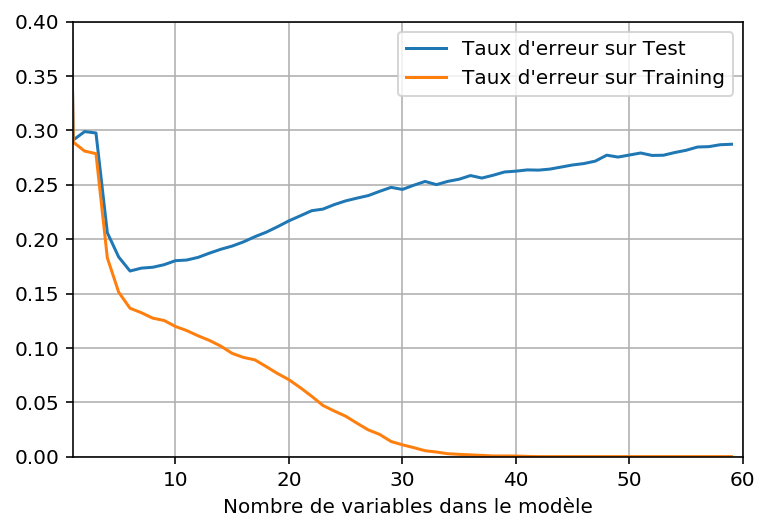

In [13]:
plt.plot(1 - sc_test, label="Taux d'erreur sur Test")
plt.plot(1 - sc_training, label="Taux d'erreur sur Training")
figcaption("Comparaison des taux d'erreur")
plt.grid(True)
plt.axis([1, 60, 0, 0.4])
xlabel('Nombre de variables dans le modèle')
_ = plt.legend()

## Le compromis biais-variance

La forme en U observée sur les courbes Performance-Flexibilité est complètement typique et est le résultat de deux propriétés antagonistes des méthodes d'apprentissage. Considérons le problème générique suivant : estimer un modèle $f(x)$ à partir d' une équation d'observation de la forme 
$$
y_0 = f(x_0) + \epsilon
$$
On montre facilement (*try to do it!* -- Refs [ici](http://www.inf.ed.ac.uk/teaching/courses/mlsc/Notes/Lecture4/BiasVariance.pdf), [là](https://robjhyndman.com/files/2-biasvardecomp.pdf), ou [là](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff#Application_to_regression) ) que l'erreur quadratique moyenne pour l'estimation du modèle $f(x)$  vérifie
\begin{equation}
\label{eq:BiasVarianceDecomposition}
\eqboxc{
\underbrace{\E{\left(y_0 - \hat{f}(x_0)\right)^2}}_{\text{Erreur quadratique moyenne}} = 
\underbrace{ \E{\left(\hat{f}(x_0)-\E{\hat{f}(x_0)}\right)^2}}_{\text{Variance}} + 
\underbrace{ \E{\hat{f}(x_0)-f(x_0)}^2}_{\text{Biais}^2} +
\underbrace{ \E{\left(y_0 -f(x_0) \right)^2 }}_{\text{Erreur irréductible}}
}
\end{equation}

Le terme $\E{\left(y_0 - \hat{f}(x_0)\right)^2}$ représente donc simplement l'erreur quadratique moyenne, et correspond à l'erreur moyenne que l'on obtiendrait en renouvelant l'estimation de $f(x_0)$, notée $\hat{f}(x_0)$, sur un grand nombre d'ensembles d'apprentissage, et en testant les différents modèles en $x_0$. L'erreur quadratique globale sera ensuite obtenue en moyennant sur tous les $x_0$ possibles. 

La relation (\ref{eq:BiasVarianceDecomposition}) nous indique donc que pour minimiser l'erreur quadratique moyenne, il faut choisir un modèle statistique qui soit à la fois à faible biais et à faible variance. Remarquons qu'en tout état de cause, l'EQM ne pourra jamais être inférieure à l'erreur irréductible due au bruit $\epsilon$. 

Que signifient ces notions de biais et de variance d'une méthode d'apprentissage statistique ? 

- La variance correspond aux *variations* de $\hat{f}(x_0)$ lorsqu'on ré-estime le modèle avec de nouveaux ensembles d'apprentissage.  Idéalement, évidemment, $\hat{f}(x_0)$ ne devrait pas trop varier, c'est-à-dire avoir une faible variance. En général, les méthodes les plus complexes ont la plus large variance. 
- Le biais, quant-à-lui, correspond à l'erreur moyenne introduite en approximant un problème réel par un modèle mathématique parfois trop simple pour rendre compte de toute la complexité. Le biais ne dépend pas de la taille de l'ensemble d'apprentissage, mais simplement d'une inadéquation du modèle.  

De manière générale, plus le modèle statistique est flexible/complexe, plus la variance augmente et le biais diminue. Lorqu'on augmente la complexité du modèle, le biais a tendance à diminuer plus rapidement que la variance n'augmente. L'erreur moyenne diminue alors. Ensuite, après une certaine degré de flexibilité, le biais est réduit et c'est l'augmentation de la variance qui l'emporte. L'erreur quadratique moyenne augmente alors. 

\begin{figure}
\centerline{\includegraphics[width=0.8\linewidth]{ErrorVsFlexibilityb.png}}
\caption{\label{fig:ErrorVsFlexibility} \'Evolution de l'erreur quadratique en fonction de la complexité du modèle. D'après Hastie et Tibishirani, cours Stanford, 2014.}
\end{figure}

De bonnes performance requièrent donc à la fois une faible variance et un faible biais. Il s'agit d'un compromis, car comme on l'a vu, ces deux indicateurs varient en sens opposé. Dans les applications réelles, il n'est pas possible de connaître les biais, variance, EQM de la méthode. *Il faut toujours garder ce compromis en tête car il s'agit d'un élément essentiel dans la sélection et la validation des différentes méthodes.* 

## Choix d'un modèle - under et overfitting

Comme on l'a illustré précédemment, il faut faire un compromis entre biais et variance, ou entre under/overftting

- under-fitting : la prédiction est trop éloignée des données d'apprentissage, 
- over-fitting : la prédiction est trop proche des données d'apprentissage. 

**L'overfitting provient de la combinaison de deux facteurs : **

- modélisation : le modèle est trop complexe (e.g., trop non-linéaire)
- dimensionnalité : trop de paramètres à estimer

Il n'est pas nécessairement possible d'éviter l'overfitting avec plus de données car : 
 
 - la quantité de données nécessaires augmente avec la dimensionnalité (*curse of dimensionality*). La figure ci-dessous illustre cette problématique
 
\begin{figure}
\centerline{\includegraphics[width=0.8\linewidth]{Ccurse_dimensionality.png}}
\caption{\label{fig:CurseOfDimensionality} Nombre de données nécessaires en fonction de la complexité du modèle. D'après [?].}
\end{figure}

Seule possibilité : réduire la dimensionnalité $\rightarrow$ estimer moins de paramètres...

# Validation, validation croisée

La meilleure solution serait de disposer de plein de données et d'un ensemble de test spécifique sur lequel on pourrait calculer l'erreur de test, ou erreur de *généralisation*. Évidemment, un tel ensemble n'est pas nécessairement disponible. Différentes méthodes, que l'on verra par ailleurs effectuent une combinaison entre l'erreur d'apprentissage et la complexité du modèle. Nous avons entrevu le *Adjusted-R2*, mais il existe aussi Cp, AIC, BIC... 

## Validation set

La technique que nous allons décrire ici consiste à isoler une partie des données sous forme de données de validation sur lesquelles on estimera les performances, tandis que le modèle sera ajusté sur les données d'apprentissage. 

Les données disponibles sont ainsi divisées en :

- un ensemble d'apprentissage (*training set*) utilisé pour l'apprentissage,
- un ensemble de validation (*validation set*) utilisé pour sélectionner les meilleurs paramètres, 
- un ensemble test (*test set*) utilisé pour évaluer les performances du modèle sélectionné. 

Deux inconvénients majeurs dans cette approche :

- Seul un sous-ensemble des données est utilisé pour estimer le modèle. On sait que plus on a de données, meilleure est l'estimation. Il y a donc là une sorte de "gachis" des données, même si l'utilisation envisagée -- optimiser le modèle en vue de sa généralisation est complètement légitime. N'utilisant pas toutes les données, il est clair que l'erreur de validation va certainement *surestimer* l'erreur sur le modèle qui serait appris sur l'ensemble des données. 
-  L'estimée sur le test de validation de l'erreur de test peut-être très variable (variance d'estimation). 


L'exemple ci-dessous reprend les données `auto.csv` de R, pour lesquelles vous vous souvenez que l'on avait estimé `mpg ~ horsepower` avec une régression polynomiale. En subdivisant aléatoirement les données en deux ensembles équilibrés (392 données au départ, deux ensembles de 196 données), et en itérant l'apprentissage et la validation une dizaine de fois, on obtient la figure \ref{fig:autodata_ordrepolynome}. On constate bien une grande variabilité de l'estimée de l'erreur de test sur les ensembles de validation...

\begin{figure}
\centerline{\includegraphics[width=0.8\linewidth]{autodata_ordrepolynome.png}}
\caption{\label{fig:autodata_ordrepolynome} Erreur de test en fonction du degré du polynôme (à gauche un seul ensemble, à droite multiples expérimentations). Tiré de [Hastie et Tibshirani].}
\end{figure}

**Ensemble de test ?** 
Très souvent, on utilisera en sus de l'ensemble de validation, un ensemble de test. Dans la mesure où les méta-paramètres (eg. ordre du polynôme, paramètres de *régularisation*, etc) du modèle sont estimés en optimisant l'erreur sur l'ensemble de validation, cette erreur sera certainement sous-estimée par rapport à une erreur calculée sur un ensemble de test indépendant. **Si on a besoin non seulement de sélectionner les paramètres du modèle, mais aussi d'estimer correctement l'erreur de généralisation, il faut se donner aussi un ensemble test indépendant).** Typiquement, on utilise souvent une séparation des données en 60% apprentissage, 20% validation, 20% test.  


## Validation croisée

### Principe

Afin de pallier au second inconvénient noté ci-dessus -- variance de l'estimée de l'erreur test, une idée naturelle est d'effectuer un moyennage de différentes estimées de l'erreur. Ceci sous-entend d'effectuer plusieurs divisions apprentissage/validation des données initiales. Pour ce qui concerne le premier inconvénient, utiliser un maximum de données pour l'apprentissage, il faut bien-sûr... utiliser un maximum de données pour l'apprentissage. La technique de validation croisée, présentée ci-dessous, est très populaire et très efficace.  

L'idée est alors de diviser aléatoirement les données en $K$ parties de tailles identiques. On laisse alors de côté la partie $k$ et on utilise les $(K-1)$ restantes pour l'apprentissage. L'erreur de test est alors calculée sur la partie mise de côté. Ceci est itéré pour $k=1, 2, \ldots, K$ et les résultats sont moyennés. 

La figure \ref{fig:kFoldCrossVal} présente cette approche pour $K=5$. 

\begin{figure}
\centerline{\includegraphics[width=0.8\linewidth]{kFoldCrossVal.png}}
\caption{\label{fig:kFoldCrossVal} Schéma de la validation croisée dans le cas $K=5$). Tiré de [?].}
\end{figure}

- Dans la mesure où chaque ensemble d'apprentissage a une dimension de $(K − 1)/K$ fois la taille initiale $N$, les estimées de l'erreur de prédiction seront trop élevées (car le modèle réel sera appris sur l'ensemble des données). 
Ce biais sera minimisé pour $K=N$, un cas particulier décrit ci-dessous. 

Sous R, au moins deux packages, `boot` et `cvTools` permettent d'effectuer efficacement une validation croisée. Dans `boot`, on disposera par exemple d'une fonction `cv.glm` qui permet d'effectuer la validation croisée pour un modèle linéaire généralisé. 

### Cas particulier - LOOCV leave-one out cross-validation

Il s'agit du cas particuler obtenu avec $K=N$, le nombre de données effectivement disponibles. ceci signifie que l'apprentissage est effectué $N$ fois, avec $N-1$ données, et que le test est effectué sur 1 seule donnée. Donc un grand nombre de calculs, mais un fort effet de moyennage. Il se trouve que **dans le cas d'une régression linéaire**, une formule explicite évite de recalculer $N$ modèles. Seul un calcul global suffit et la technique devient alors très efficace. Dans certains cas, cette approche est utile ;  cependant, du fait que les ensembles d'apprentissage sont très corrélés, la variabilité devient insuffisante et on ne gagne pas tant que cela. On s'aperçoit de fait qu'en pratique un bon choix sera typiquement $K=5$ ou $K=10$.

### Se planter avec la validation croisée

Il est important de souligner que pour utiliser correctement la validation croisée, il faut l'utiliser sur l'ensemble de la procédure et pas sur une sous partie. Il faut notamment éviter de préselectionner les variables importantes *features* à partir de l'ensemble des données puis n'utiliser que ces variables dans un sous modèle. Une telle approche a pour effet de nettement surestimer les performances de la méthode. 

### Un exemple d'application

On reprend simplement l'exemple de la régression polynomiale présenté en début de chapitre. Au lieu d'estimer les performances sur un grand nombre de réplicas complètement hypothétiques, on effectue ceci par validation croisée à partir d'un unique jeu de données. 

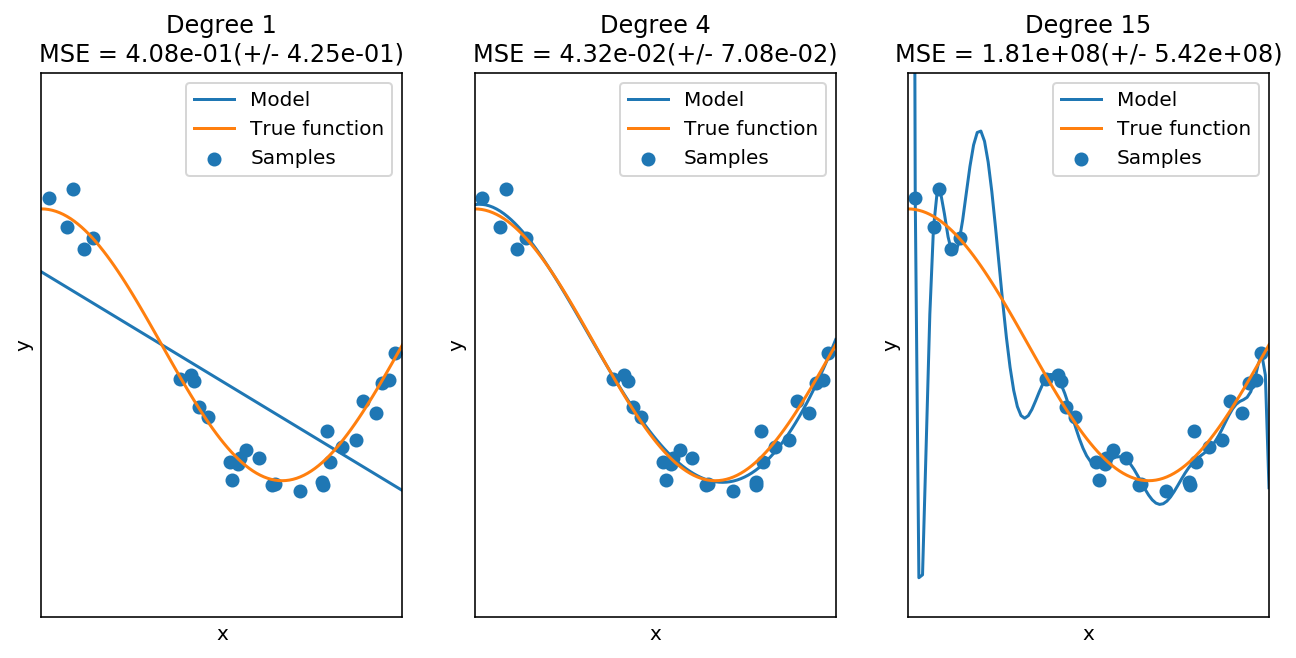

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn import cross_validation

np.random.seed(0)

n_samples = 30
degrees = [1, 4, 15]

true_fun = lambda X: np.cos(1.5 * np.pi * X)
X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

plt.figure(figsize=(11, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    poly = PolynomialFeatures(degree=degrees[i], include_bias=False)
    reg = LinearRegression()
    XX=poly.fit_transform(X[:,np.newaxis])
    reg.fit(XX, y)

    # Evaluate the models using crossvalidation
    scores = -cross_validation.cross_val_score(reg,
        XX, y, scoring="mean_squared_error", cv=10) #<-- Gros bouzin ici car MSE négatif 
                                    # voir https://github.com/scikit-learn/scikit-learn/issues/2439
    #scores=erreur_moyenne_test(100,order=degrees[i])
    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, reg.predict(poly.fit_transform(X_test[:, np.newaxis])), 
             label="Model")
    plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title("Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(
        degrees[i], scores.mean(), scores.std()))
figcaption("Comparaison des résultats pour une régression polynomiale avec différents degrés",
              label="fig:compare_res_polreg")

/home/bercherj/.local/lib/python3.5/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log
/home/bercherj/.local/lib/python3.5/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log


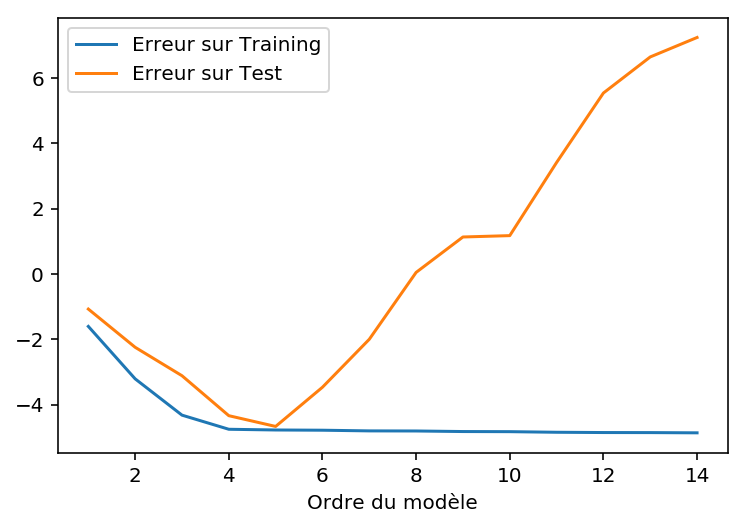

In [15]:
# Tracé des courbes de performance
# On tire au hasard une base d'apprentissage, une base de test
# On apprend sur l'apprentissage, puis on teste sur apprentissage et sur test
# ce pour tous les ordres possibles
# On itère là dessus M fois

# Définition du problème simulé
n_samples = 100
true_fun = lambda X: np.cos(1.5 * np.pi * X)

# Degré max à tester 
max_order = 15
sc_test = np.zeros((max_order))
sc_training = np.zeros((max_order))

X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1  # jeu d'apprentissage
ytest = true_fun(X) + np.random.randn(n_samples) * 0.1  # jeu de test

for order in range(1, max_order):
    poly = PolynomialFeatures(degree=order)
    XX = poly.fit_transform(
        X[:,
          np.newaxis])  # permet de générer toutes les variables explicatives
    reg = linear_model.LinearRegression()  # instance régression linéaire 
    reg.fit(XX, y)  # apprentissage 
    sc_training[order] += np.mean(
        (reg.predict(XX) - y)**2)  # calcul RSS training
    # sc_test[order]+=np.sum((reg.predict(XX)-ytest)**2) # calcul RSS test   
    # Evaluate the models using crossvalidation
    scores = -cross_validation.cross_val_score(
        reg, XX, y, scoring="mean_squared_error",
        cv=10)  #<-- Gros bouzin ici car MSE négatif 
    # voir https://github.com/scikit-learn/scikit-learn/issues/2439
    sc_test[order] += np.mean(scores)

plt.plot(np.log(sc_training), label="Erreur sur Training")
plt.plot(np.log(sc_test), label="Erreur sur Test")
plt.legend()
plt.xlabel("Ordre du modèle")
figcaption(
    "Comparaison des EQM sur Test et Training", label="compare_perfs_polreg")

# Le bootstrap

*The Baron had fallen to the bottom of a deep lake. Just
when it looked like all was lost, he thought to pick himself
up by his own bootstraps.*

Les Aventures du baron de Münchausen par Rudolph Erich Raspe

Il s'agit également d'une technique de rééchantillonnage des données, particulièrement élégante et efficace. Elle est utilisée notamment pour quantifier l'incertitude associée à un estimateur ou à une méthode d'apprentissage statistique, en particulier lorsque les dérivations analytiques deviennent difficiles.  Elle repose sur des hypothèses très faibles sur les distributions sous-jacentes (essentiellement l'indépendance des données) et peut donc être utilisée dans des situations très générales. Elle peut par exemple fournir une estimée de l'erreur standard sur un coefficient, ou un intervalle de confiance sur ce coefficient. Comme on le verra, elle peut également permettre d'évaluer les performances d'une méthode.

## Quantification de l'incertitude

Supposons que l'on ait estimé un certain coefficient dans un modèle (coefficient de régression, coeffcients de l'hyperplan séparateur dans une discrimination, hyperparamètre), et que l'on veuille quantitifier l'incertitude sur ce coefficient. L'approche analytique classique consiste à *se donner une loi sur les incertitudes* $\epsilon$, et donc *en déduire* une loi sur l'estimateur $\hat{\beta}$. On peut alors calculer l'écart-type correspondant, qui correspond aux variations attendues dans une série d'*expériences imaginaires* où on recalculerait de nouveaux estimateurs pour chacune de ces expériences. On peut également calculer un intervalle de confiance associé, à un niveau $\alpha$, ou encore une $p$-value qui donne la probabilité de dépasser la valeur actuelle, par pur hasard, si le coefficient est en fait nul (hypothèse nulle H0). Ces dérivations analytiques supposent donc de connaître toutes les lois mises en jeu, et de connaître précisément le mécanisme qui conduit à l'estimateur. Lorsque ces lois sont mal connues, ou lorsque le mécanisme devient complexe (succession de méthodes, non-linéarités, etc), il devient difficile  de calculer la loi de l'estimateur et par suite de quantifier son incertitude.  

### Premier exemple

In [16]:
%%R -o VA
library(MASS)
?VA

R Help on ‘VA’VA                    package:MASS                     R Documentation

_V_e_t_e_r_a_n'_s _A_d_m_i_n_i_s_t_r_a_t_i_o_n _L_u_n_g _C_a_n_c_e_r _T_r_i_a_l

_D_e_s_c_r_i_p_t_i_o_n:

     Veteran's Administration lung cancer trial from Kalbfleisch &
     Prentice.

_U_s_a_g_e:

     VA
     
_F_o_r_m_a_t:

     A data frame with columns:

     ‘stime’ survival or follow-up time in days.

     ‘status’ dead or censored.

     ‘treat’ treatment: standard or test.

     ‘age’ patient's age in years.

     ‘Karn’ Karnofsky score of patient's performance on a scale of 0 to
          100.

     ‘diag.time’ times since diagnosis in months at entry to trial.

     ‘cell’ one of four cell types.

     ‘prior’ prior therapy?

_S_o_u_r_c_e:

     Kalbfleisch, J.D. and Prentice R.L. (1980) _The Statistical
     Analysis of Failure Time Data._ Wiley.

_R_e_f_e_r_e_n_c_e_s:

     Venables, W. N. and Ripley, B. D. (20

treat
1    AxesSubplot(0.125,0.125;0.775x0.755)
2    AxesSubplot(0.125,0.125;0.775x0.755)
Name: stime, dtype: object

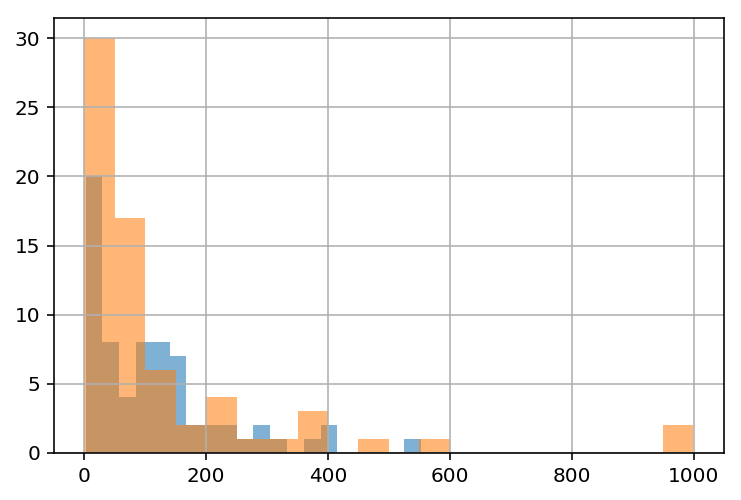

In [17]:
VA.dropna().groupby('treat')['stime'].hist(bins=20, alpha=0.57)

In [18]:
# Calcul des moyennes sur les deux groupes :
means = VA.dropna().groupby('treat')['stime'].mean()
print(means)
print("Différence des moyennes : ", means[1]-means[0])

treat
1    115.144928
2    128.205882
Name: stime, dtype: float64
Différence des moyennes :  13.060954816709298


La question est alors, est-ce que cette différence est significative ou pas ?

**Approche classique** Construire la statistique 
$$
t = \frac{S-H}{\hat{\sigma}}
$$
où S est la statistique que l'on veut tester, H l'hypothèse nulle, $\hat{\sigma}$ l'erreur standard sur S. Dans notre cas, S est la différence des deux moyennes empiriques, et $\hat{\sigma}^2$ est la somme des deux variances correspondantes. Si on suppose que les données sont gaussiennes (ce qui est faux), alors $t$ sera une variable de Student. On peut alors évaluer la $p$-value associée. 

In [19]:
means = VA.dropna().groupby('treat')['stime'].mean()
stds = VA.dropna().groupby('treat')['stime'].std()
hatsigma=np.sqrt(np.sum(stds**2))
t = (means[1]-means[0])/hatsigma
print("La statistique vaut alors t=",t)
# On calcule la p-value par 1-cdf(t)=sf(t) | cdf: cumulative distribution function, sf: survival function
# df: nombre de degrés de liberté
print("Sa p-value est", scipy.stats.t.sf(t,df=69))

La statistique vaut alors t= 0.058248196937767026
Sa p-value est 0.47685964616553317


On en conclue qu'une différence de 13 jours **n'est pas significative**; 

### Second exemple
(d'après Hastie et Tibshirani, Stanford, 2014) 

On cherche le meilleur paramètre de mélange entre deux populations de manière à minimiser la variance de l'ensemble ; il s'agit par exemple des marchandises provenant de deux fournisseurs, ou des gains/rendements sur deux paquets d'actions. On cherche donc à minimiser
$$
\mathrm{Var}\left[{\alpha X+(1-\alpha Y)}\right]
$$
Il n'est pas bien compliqué de montrer que la solution est donnée par
$$
\alpha = \frac{\sigma_Y^2-\sigma_{XY} }{\sigma_X^2 + \sigma_Y^2-2\sigma_{XY}}.
$$
En pratique, la valeur sera estimée en $\hat{\alpha}$ en remplaçant les différentes variances et covariances par leurs estimées.

**Simulation**: On prend $X \sim \mathcal{N}(0,1)$, $Y = Z+ 0.5X$ avec $Z \sim \mathcal{N}(0,1)$ indépendant de $X$. Dans ces conditions, on a $\sigma_X^2=1$, $\sigma_Y^2=1.25$, et $\sigma_{XY}=0.5$. La valeur théorique de $\alpha$ est alors $\alpha=0.6$.

On effectue 1000 expériences où on tire 100 échantillons de $X$ et $Y$ et où l'on calcule $\alpha$. On stocke ensuite les différentes estimées. 


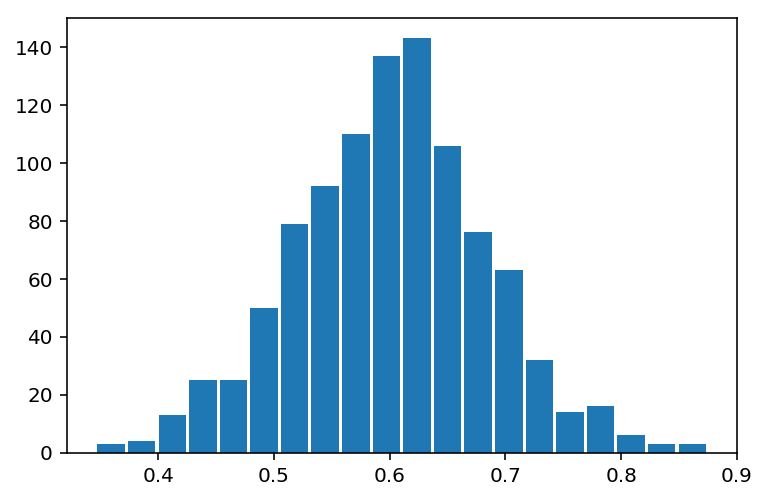

In [20]:
K = 1000
alpha = np.empty(K)
for k in range(K):
    X = np.random.normal(scale=1.0, size=100)
    Z = np.random.normal(scale=1.0, size=100)
    Y = Z + 0.5 * X
    alpha[k] = (np.var(Y) - np.cov(X, Y)[0][1]) / (
        np.var(X) + np.var(Y) - 2 * np.cov(X, Y)[0][1])

_ = plt.hist(alpha, bins=20, rwidth=0.9)
#plt.figure()
#plt.boxplot(alpha)

In [21]:
print("Moyenne des alpha :", np.mean(alpha))
print("Ecart-type des alpha :", np.std(alpha))

Moyenne des alpha : 0.6005455447875899
Ecart-type des alpha : 0.08265114528050074


Sous l'approximation gaussienne, on peut alors par exemple en déduire un intervalle de confiance à 95% (moyenne $\pm$ 2 écarts-type).  

## Principe du *Bootstrap*


### Principe

Bien évidemment, dans la vraie vie, il n'est pas possible de générer de nouveaux échantillons car on ne dispose que d'un seul jeu de données... *Cette procédure n'est pas applicable.*

L'astuce est la suivante. Vous savez que la fonction de répartition est la fonction qui permet de transformer une variable aléatoire en une autre variable aléatoire de densité uniforme. Réciproquement, l'inverse de la fonction de répartition, la fonction quantile, permet de transformer une variable uniforme en une variable de loi donnée. 

/usr/local/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


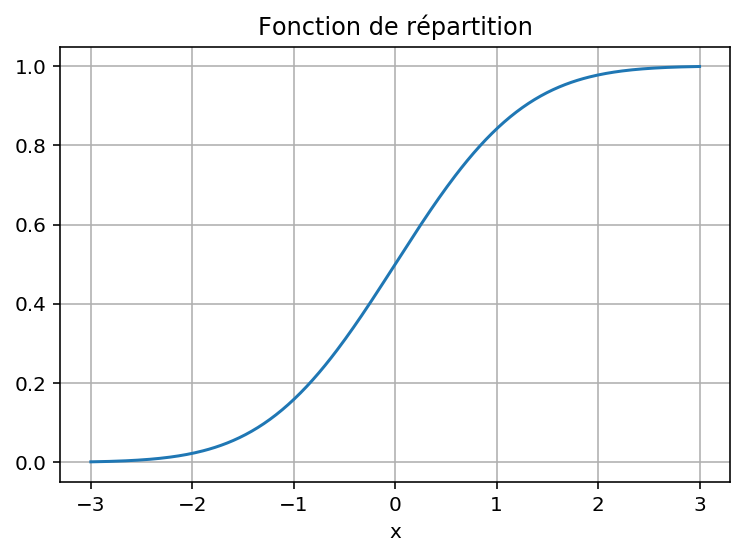

In [22]:
# Exemple de fonction de répartition
x = np.linspace(-3, 3, 300)
plt.plot(x, scipy.stats.norm.cdf(x))
plt.grid("on")
plt.xlabel("x")
_ = plt.title("Fonction de répartition")

Pour *échantillonner* à partir de cette loi, on peut tirer des variables aléatoires de manière uniforme sur [0,1], puis on lit sur l'axe X la valeur associée à ce "y". 

Considérons maintenant la fonction de répartition empirique :

<BarContainer object of 50 artists>

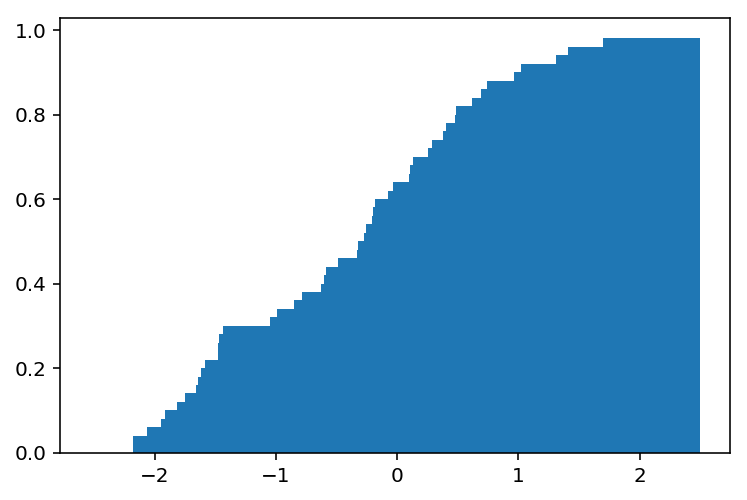

In [23]:
X = np.random.randn(50)
# Calcul de la fonction de répartition empirique
s = np.sort(X)
yvals = np.arange(len(s)) / len(s)
plt.bar(s, yvals)

On observe donc que si on échantillonne à partir de la fonction de répartition empirique, au lieu de la fonction de répartition théorique, eh bien on va retomber sur des valeurs de l'échantillon initial... On peut même retomber plusieurs fois sur une même donnée. Il est ainsi possible de **générer un nouvel échantillon** de la manière suivante :
- tirer au hasard une donnée uniformément parmi les $N$ données disponibles,
- remettre la donnée dans les choix disponibles
itérer tant qu'on n'a pas atteint le nombre de tirages voulus. 

On parle de "tirage aléatoire avec remise". L'ensemble de la procédure conduit à générer un échantillon *bootstrap*. 

On peut dès lors générer autant d'échantillons bootstrap que l'on souhaite et faire des calculs avec, *comme si* on disposait d'un grand nombre d'expériences aléatoires. 

### Exemples



#### Comparaison de moyennes

Reprenons l'exemple de la comparaison des moyennes sur la base des vétérans. On a pu faire un calcul analytique à l'aide des données disponibles, qui nous a amené à une p-value non significative pour l'écart constaté de 13 jours. Dans la procédure bootstrap, on peut rééchantillonner suivant les deux ensembles de test, calculer les moyennes empiriques correspondantes, leur différence et étudier la distribution de probabilité de cette différence. 

In [24]:
s = VA.dropna()[['treat', 'stime']]
set1 = s[s['treat'] == '1']['stime']
set2 = s[s['treat'] == '2']['stime']

In [25]:
import sklearn

In [26]:
sklearn.utils.resample()

In [27]:
# On fait cela en Python
# Pour rééchantillonner, on utilise np.random.choice
"""choice(a, size=None, replace=True, p=None)
Generates a random sample from a given 1-D array"""
# On peut également utiliser sklearn.utils.resample()

B = 1000
m1 = np.empty(shape=(B, ))
m2 = np.empty(shape=(B, ))
for b in range(B):
    b1 = np.random.choice(set1, size=100)
    b2 = np.random.choice(set2, size=100)
    m1[b] = np.mean(b1)
    m2[b] = np.mean(b2)

Il est possible de tracer l'histogramme de la différence des deux moyennes : 

moyenne bootstrap de la différence des moyennes 13.07971
écart-type bootstrap de la différence des moyennes 22.28011973073529


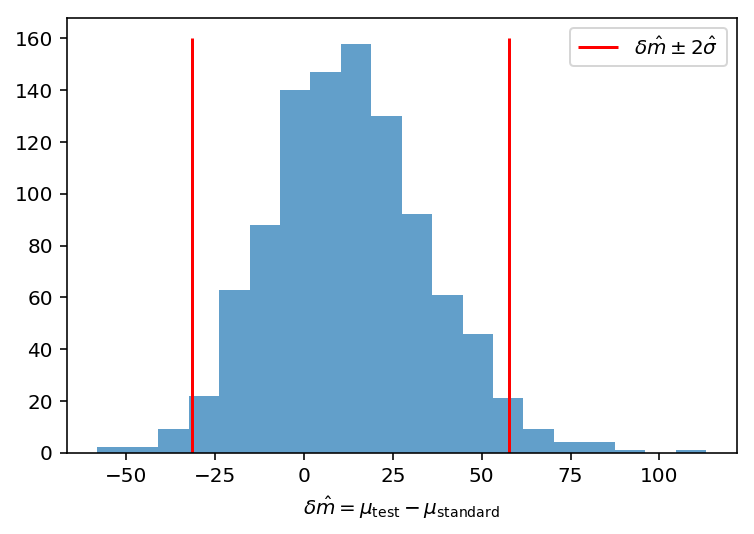

In [28]:
_ = plt.hist(m2 - m1, 20, alpha=0.7)
plt.xlabel('$\delta \hat{m}=\mu_\mathrm{test}-\mu_\mathrm{standard}$')
mm = np.mean(m2 - m1)
ss = np.std(m2 - m1)
print("moyenne bootstrap de la différence des moyennes", mm)
print("écart-type bootstrap de la différence des moyennes", ss)
plt.vlines(
    [mm - 2 * ss, mm + 2 * ss],
    0,
    160,
    colors='r',
    linestyles='solid',
    label='$\delta \hat{m}\pm 2\hat\sigma$')
plt.legend()

Même si la différence des moyennes est toujours de l'ordre de 13, on voit qu'une différence de zéro est complètement à l'intérieur de l'intervalle de confiance à 95%, et qu'on ne peut donc absolument pas rejeter l'hypothèse nulle $\delta\hat{m}=0$. 

#### Paramètre de mélange
Comme second exemple, nous pouvons revenir sur le problème de minimisation de la variance d'un mélange où l'on recherchait le paramètre $\alpha$. Nous avons simulé le problème en générant une série d'échantillons et en examinant l'histogramme. Dans la réalité on ne dispose que d'un échantillon... 

Grace au bootstrap on peut quand même obtenir, numériquement, des statistiques sur le résultat. 

moyenne bootstrap sur alpha=0.6714840957139699, alpha sur l'échantillon de départ: 0.6721552815277686
écart-type bootstrap sur alpha 0.09012311741673434


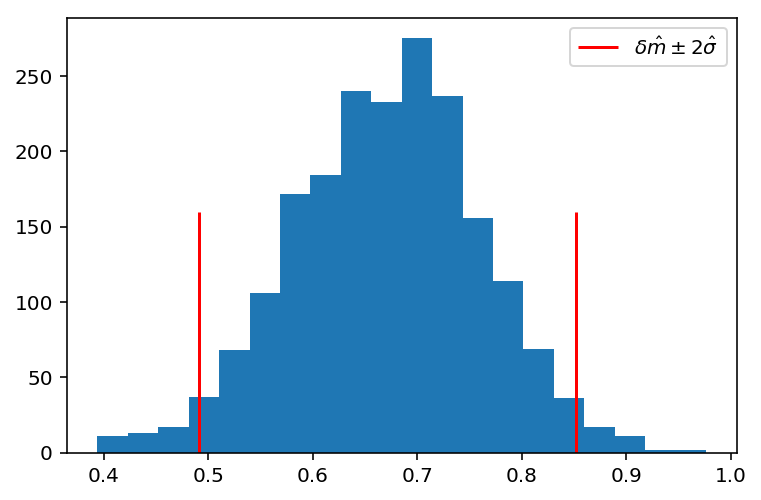

In [29]:
# Au départ, on dispose donc de deux séries de "mesures", X et Y
X = np.random.normal(scale=1.0, size=100)
Z = np.random.normal(scale=1.0, size=100)
Y = Z + 0.5 * X
alpha_ini = (np.var(Y) - np.cov(X, Y)[0][1]) / (
    np.var(X) + np.var(Y) - 2 * np.cov(X, Y)[0][1])

#On rééchantillonne par bootstrap ces deux échantillons
B = 2000
alphab = np.empty(shape=(B, ))
for b in range(B):
    I = np.random.choice(100, size=100)  # Choix des index
    Xb = X[I]
    Yb = Y[I]
    alphab[b] = (np.var(Yb) - np.cov(Xb, Yb)[0][1]) / (
        np.var(Xb) + np.var(Yb) - 2 * np.cov(Xb, Yb)[0][1])

_ = plt.hist(alphab, bins=20)
mm = np.mean(alphab)
ss = np.std(alphab)
print("moyenne bootstrap sur alpha={}, alpha sur l'échantillon de départ: {}".
      format(mm, alpha_ini))
print("écart-type bootstrap sur alpha", ss)
plt.vlines(
    [mm - 2 * ss, mm + 2 * ss],
    0,
    160,
    colors='r',
    linestyles='solid',
    label='$\delta \hat{m}\pm 2\hat\sigma$')
plt.legend()

On retrouve les mêmes résultats que précédemment où on utilisait de nouvelles données, alors qu'avec le bootstrap on retrouve des résultats similaires en n'utilisant que les données initiales. 

De manière générale, on voit donc que 
- Le bootstrap est une méthode puissante et flexible qui permet de quantifier l'incertitude associée à un estimateur donné ou à une méthode d'apprentissage globale. 
- Le bootstrap peut permettre de d'obtenir une estimée de l'*erreur standard* ou un intervalle de confiance 


#### Régression linéaire

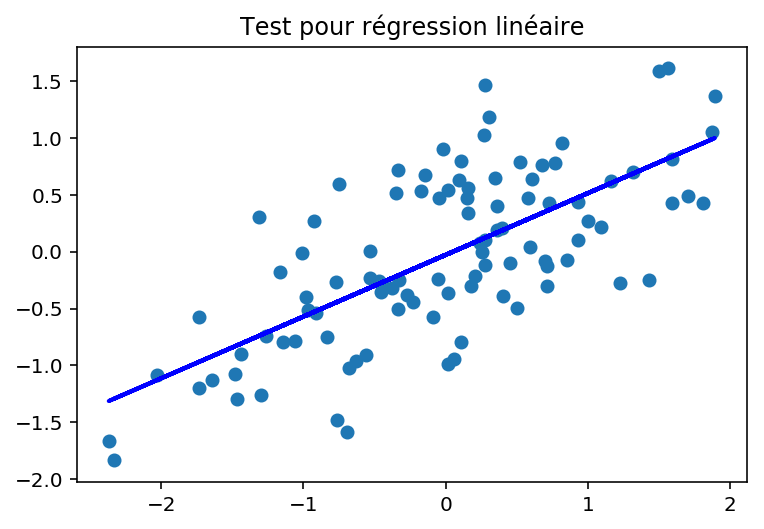

In [30]:
from sklearn import linear_model
clf = linear_model.LinearRegression()
# Linear regression
X = np.random.normal(scale=1.0, size=100)
Z = np.random.normal(scale=1.0, size=100)
Y = 0.5 * X + 0.666 * Z
X = np.reshape(X, (100, 1))
clf.fit(X, Y)

plt.scatter(X, Y)
plt.plot(X, clf.predict(X), color='blue', linewidth=2)
_ = plt.title("Test pour régression linéaire")
# sauvegarde des coeffs du modèle complet
slope_ini = clf.coef_
intercept_ini = clf.intercept_

Maintenant, à partir de ces mêmes données, on peut rechercher à quantifier la précison de notre régression linéaire. Pour cela, on fait des calculs de sensibilité (c'est possible ici pour ce modèle simple), ou on quantifie par simulation numérique en utilisant le bootstrap. 

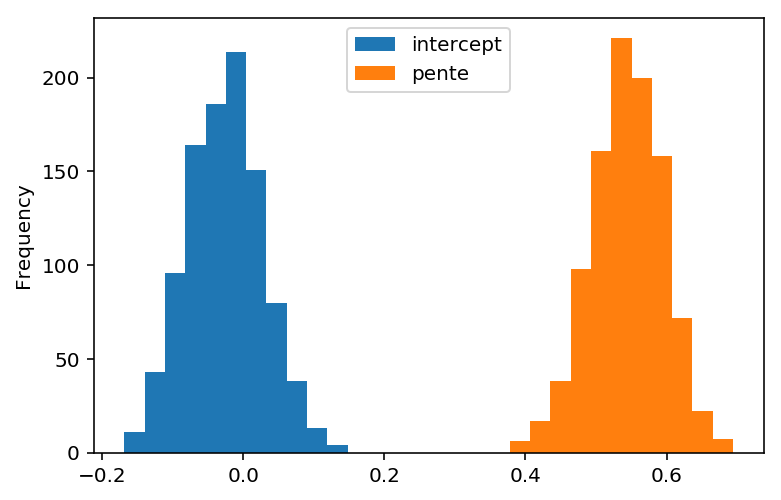

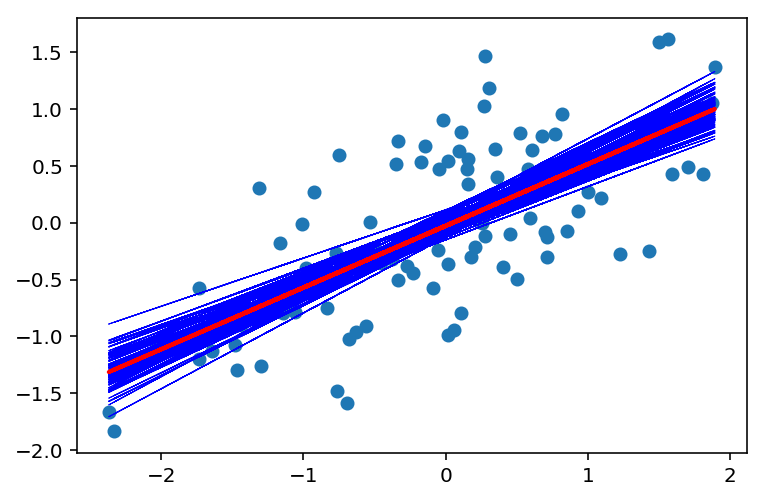

In [31]:
import pandas as pd
B = 1000
coeffs_boot = pd.DataFrame(index=range(B), columns=['intercept', 'pente'])
for b in range(B):
    I = np.random.choice(100, size=100)  # Choix des index
    Xb = X[I]
    Yb = Y[I]
    clf.fit(Xb, Yb)
    coeffs_boot.iloc[b] = clf.intercept_, clf.coef_[0]

coeffs_boot.plot(kind='hist', bins=30)
figcaption(
    "Histogrammes des différents coefficients", label="fig:reg_coeffs_boot")
mm = np.mean(coeffs_boot)
ss = np.std(coeffs_boot)

plt.figure()
plt.scatter(X, Y)
figcaption(
    "Nuage de point et estimées de la doite de régression et de son incetitude",
    label="fig:reg_scatter_boot")
for b in range(0, B, 10):  #On ne trace pas toutes les droites
    plt.plot(
        X,
        coeffs_boot.iloc[b]['intercept'] + coeffs_boot.iloc[b]['pente'] * X,
        color='blue',
        linewidth=0.5)

plt.plot(X, intercept_ini + slope_ini * X, color='red', linewidth=2)

On obtient ainsi des histogrammes sur les valeurs des différents coefficients : on peut ainsi quantifier l'incertitude associée, soit sous la forme d'une erreur standard, soit sous la forme d'un intervalle de confiance bootstrap. Par ailleurs, comme on le voit sur le second graphique \ref{fig:reg_scatter_boot}, il semble l'incertitude de prédiction soit plus importante sur les extrémités (car en fait il y a moins de données) qu'au centre. 

Étant donné les échantillons bootstrap, et par la suite l'ensemble des pentes correspondantes, on peut parfaitement calculer les prédictions moyennes et les écarts-type sur ces prédictions.

In [32]:
preds = pd.DataFrame(
    index=np.linspace(-3, 3, 100), columns=['mean_pred', 'ste'])

# pour chacun des xx, calcul de l'ensemble des prédictions et de leur écart-type
coeffs = np.array(coeffs_boot)  # matrice des coeffs
for x in preds.index:
    s = coeffs_boot.dot(np.array([1, x]))  #coeffs.dot(np.array([1, x]))
    preds.loc[x].mean_pred = s.mean()
    preds.loc[x].ste = s.std()

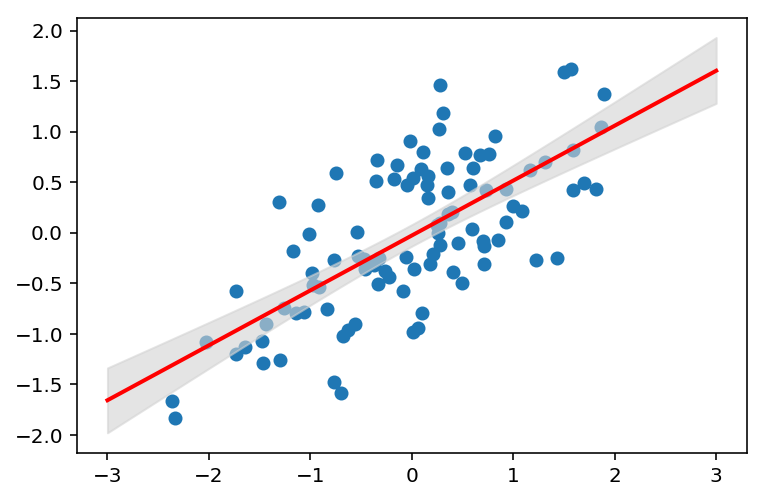

In [33]:
XX = np.array(preds.index)
plt.scatter(X, Y)
plt.plot(XX, intercept_ini + slope_ini * XX, color='red', linewidth=2)
_ = plt.fill_between(
    XX,
    np.array(preds.mean_pred - 2 * preds.ste, dtype(np.float64)),
    np.array(preds.mean_pred + 2 * preds.ste, dtype(np.float64)),
    alpha=0.6,
    color="lightgray")

Pour x=-2.5, on a donc une ainsi une prédiction de 

In [34]:
def pred(x):
    s = coeffs_boot.dot(np.array([1, x]))  #coeffs.dot(np.array([1, x]))
    print("Prédiction:", s.mean())
    print("Intervalle de confiance bootstrap à 95%: [",
          s.mean() - 2 * s.std(), s.mean() + 2 * s.std(), "]")
    return s.mean(), s.std()


pred(-2.5)

Prédiction: -1.3867365967216205
Intervalle de confiance bootstrap à 95%: [ -1.6604604832875907 -1.1130127101556504 ]


(-1.3867365967216205, 0.13686194328298504)

## Bootstrap et estimation de l'erreur de prédiction 

Le bootstrap peut-il permettre d'estimer l'erreur de prédiction ?
Il s'agit là d'une question naturelle, compte tenu des développements précédents. 

- Dans le cadre de la validation croisée, chacun des $K$ ensembles de validation est complètement des distinct des $K-1$ autres ensembles utilisés pour l'apprentissage, sans le moindre recouvrement. L'hypothèse est cruciale car la validation ne doit pas comprendre des données qui auraient été vues lors de l'apprentissage. 

-  Pour estimer l'erreur de prédiction on pourrait penser à utiliser les échantillons bootstrap pour l'apprentissage et les données initiales comme ensemble de validation. Comme chaque échantillon bootstrap comprend environ 2/3 des échantillons de départ, on a un gros recouvrement entre apprentissage et validation. L'erreur de prédiction sera alors nettement sous-estimée. 

- L'autre solution : données originales pour l'apprentissage et validation sur bootstrap est encore moins bonne. 

- Il serait possible de ne faire les prédictions que sur les données qui n'apparaissent pas dans les échantillons bootstrap, mais on imagine bien que ceci impose de "suivre" les données, et que la méthode devient extrêmement compliquée. 
- Au final, une validation croisée est plus simple et efficace...